## Initial settings

In [2]:
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [48]:
import json
import boto3
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
import matplotlib.pyplot as plt
from PIL import Image
import boto3
from time import sleep

In [17]:
session = sagemaker.Session()

bucket_sagemaker = session.default_bucket()
print("Default Bucket: {}".format(bucket_sagemaker))

region = session.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-798714931926
AWS Region: us-east-1
RoleArn: arn:aws:iam::798714931926:role/service-role/AmazonSageMaker-ExecutionRole-20230319T062026


## Copy content and style images to S3

In [7]:
CONTENT_IMAGES_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/content-images/'
STYLE_IMAGES_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/style-images/'
OUTPUT_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/output/'

In [11]:
!aws s3 cp  ./data/input/content-images  {CONTENT_IMAGES_BUCKET}  --recursive

upload: data/input/content-images/sherlock.jpeg to s3://sagemaker-studio-sr1encmpcxc/content-images/sherlock.jpeg
upload: data/input/content-images/YellowLabradorLooking_new.jpeg to s3://sagemaker-studio-sr1encmpcxc/content-images/YellowLabradorLooking_new.jpeg
upload: data/input/content-images/jennifer-lawrence.png to s3://sagemaker-studio-sr1encmpcxc/content-images/jennifer-lawrence.png
upload: data/input/content-images/sphynx_cat.jpg to s3://sagemaker-studio-sr1encmpcxc/content-images/sphynx_cat.jpg
upload: data/input/content-images/lavaux.jpeg to s3://sagemaker-studio-sr1encmpcxc/content-images/lavaux.jpeg
upload: data/input/content-images/monalisa.jpg to s3://sagemaker-studio-sr1encmpcxc/content-images/monalisa.jpg
upload: data/input/content-images/debarcadere.jpeg to s3://sagemaker-studio-sr1encmpcxc/content-images/debarcadere.jpeg


In [13]:
%%capture
!aws s3 cp  ./data/input/style-images  {STYLE_IMAGES_BUCKET}  --recursive

## Run estimators

#### Setup and Fit estimators

In [56]:
estimator_names = []

num_steps = 300
num_iter = 2
style_weight = 1e6
content_weight = 1e1

content_image = 'sphynx_cat.jpg'

style_images = [
    'Pierre-Auguste_Renoir_52.jpg',
    'Pierre-Auguste_Renoir_250.jpg ',
    'Andy_Warhol_66.jpg',
    'Pablo_Picasso_130.jpg',
    'Edvard_Munch_3.jpg',
    'Georges_Seurat_23.jpg',
    'Vincent_van_Gogh_313.jpg',
    'Vincent_van_Gogh_69.jpg',
    'Vincent_van_Gogh_872.jpg',
]

for style_img in style_images:
    
    hyperparameters = {
        "content_image":content_image ,
        "style_image": style_img,
        "num_steps": num_steps,
        "num_iter": num_iter,
        "style_weight": style_weight,
        "content_weight": content_weight
    }
    hyperparams_keys= list(hyperparameters.keys())
    
    estimator = PyTorch(
        entry_point="style_transfer_pytorch.py",
        base_job_name='pytorch-style-transfer22',
        role=role,
        framework_version="1.8.0",
        instance_count=1,
        instance_type="ml.m5.large",
        py_version='py3',
        hyperparameters=hyperparameters,
        output_path=OUTPUT_BUCKET # SM_OUTPUT_DATA_DIR
    )


    channels = {
        "CONTENT_DATA": CONTENT_IMAGES_BUCKET, #'SM_CHANNEL_CONTENT_DATA'
        "STYLE_DATA": STYLE_IMAGES_BUCKET, #SM_CHANNEL_STYLE_DATA
        "SOMETHING-else": "s3://sagemaker-studio-sr1encmpcxc/", #SM_CHANNEL_SOMETHING-ELSE
    }
    
    estimator.fit(channels, wait=False)
      
    estimator_names.append(estimator._current_job_name)
    
estimator_names

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-style-transfer22-2023-04-15-11-09-01-111
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-style-transfer22-2023-04-15-11-09-02-400
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-style-transfer22-2023-04-15-11-09-03-496
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-style-transfer22-2023-04-15-11-09-04-198
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with 

['pytorch-style-transfer22-2023-04-15-11-09-01-111',
 'pytorch-style-transfer22-2023-04-15-11-09-02-400',
 'pytorch-style-transfer22-2023-04-15-11-09-03-496',
 'pytorch-style-transfer22-2023-04-15-11-09-04-198',
 'pytorch-style-transfer22-2023-04-15-11-09-05-115',
 'pytorch-style-transfer22-2023-04-15-11-09-06-670',
 'pytorch-style-transfer22-2023-04-15-11-09-07-688',
 'pytorch-style-transfer22-2023-04-15-11-09-08-256',
 'pytorch-style-transfer22-2023-04-15-11-09-09-503']

In [57]:
estimator_names

['pytorch-style-transfer22-2023-04-15-11-09-01-111',
 'pytorch-style-transfer22-2023-04-15-11-09-02-400',
 'pytorch-style-transfer22-2023-04-15-11-09-03-496',
 'pytorch-style-transfer22-2023-04-15-11-09-04-198',
 'pytorch-style-transfer22-2023-04-15-11-09-05-115',
 'pytorch-style-transfer22-2023-04-15-11-09-06-670',
 'pytorch-style-transfer22-2023-04-15-11-09-07-688',
 'pytorch-style-transfer22-2023-04-15-11-09-08-256',
 'pytorch-style-transfer22-2023-04-15-11-09-09-503']

## Save estimators results

In [46]:
INPUT_LOCAL_PATH = './data/input'
INPUT_CONTENT_PATH = f'{INPUT_LOCAL_PATH}/content-images'
INPUT_STYLE_PATH = f'{INPUT_LOCAL_PATH}/style-images'

OUTPUT_LOCAL_PATH = './data/output'
OUTPUT_DOWNLOADS_PATH = f'{OUTPUT_LOCAL_PATH}/model-downloads'
OUTPUT_RESULTS_PATH = f'{OUTPUT_LOCAL_PATH}/model-results'

METADATA_LOCAL_PATH = './estimators_metadata'

def save_estimator_hyperparams(estimator):
    hyperparams = estimator.hyperparameters()
    estimator_file_path = f"{METADATA_LOCAL_PATH}/{hyperparams['sagemaker_job_name']}.json"
    with open(estimator_file_path, "w") as f:
        json.dump(hyperparams, f)

        
def download_output_images(estimator) -> str:
    estimator_name = eval(estimator.hyperparameters()['sagemaker_job_name'])
    
    image_source_path = f'{OUTPUT_BUCKET}{estimator_name}/output/output.tar.gz'
    tar_image_dest_path = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}-output.tar.gz'
    image_dest_path = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'
    
    ! aws s3 cp {image_source_path}  {tar_image_dest_path}
    ! mkdir -p {image_dest_path}
    ! tar -xzf {tar_image_dest_path} -C {image_dest_path} --no-same-owner
    ! rm {tar_image_dest_path}


def save_experiment(estimator, hyperparams_keys):
    print(hyperparams_keys)
    hyperparams = estimator.hyperparameters()
    
    content_img_name = eval(hyperparams['content_image'])
    style_img_name = eval(hyperparams['style_image'])
    estimator_name = eval(hyperparams['sagemaker_job_name'])
    output_images_dir = f'{OUTPUT_DOWNLOADS_PATH}/{estimator_name}'

    # Define input paths for the images
    content_image_path = f'{INPUT_CONTENT_PATH}/{content_img_name}'
    style_image_path = f'{INPUT_STYLE_PATH}/{style_img_name}'
    output_image_path = final_image_path(output_images_dir, eval(hyperparams['num_iter']))
    
    # Define output path for the results summary image
    output_experiment_path = f'{OUTPUT_RESULTS_PATH}/{estimator_name}.jpg'
    
    # Load images
    images = [
        ('content_image', Image.open(content_image_path)),
        ('style_image', Image.open(style_image_path)),
        ('output_image', Image.open(output_image_path))
    ]

    # Plot images
    fig, axs = plt.subplots(1, 3,  figsize=(15, 5))
    for (img_type, img_data), ax in zip(images, axs):
        ax.imshow(img_data)
        ax.axis('off')
        ax.set_title(img_type)
     
    title = " || ".join([f"{key}: {hyperparams.get(key)}" for key in hyperparams_keys])
    plt.suptitle(title)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(output_experiment_path, dpi=100, bbox_inches='tight')
        
        
def final_image_path(output_images_dir: str, num_iter: int) -> str:
    return f'{output_images_dir}/result-iter-{num_iter - 1}.jpg'

    
# # Uncomment to load an existing estimator and test
# estimator = Estimator.attach("pytorch-style-transfer22-2023-04-11-09-06-19-859") 
# download_output_images(estimator)
# save_estimator_hyperparams(estimator)
# save_experiment(estimator, ['content_image', 'style_image', 'num_steps', 'num_iter', 'style_weight', 'content_weight'])

In [58]:
estimator_names

['pytorch-style-transfer22-2023-04-15-11-09-01-111',
 'pytorch-style-transfer22-2023-04-15-11-09-02-400',
 'pytorch-style-transfer22-2023-04-15-11-09-03-496',
 'pytorch-style-transfer22-2023-04-15-11-09-04-198',
 'pytorch-style-transfer22-2023-04-15-11-09-05-115',
 'pytorch-style-transfer22-2023-04-15-11-09-06-670',
 'pytorch-style-transfer22-2023-04-15-11-09-07-688',
 'pytorch-style-transfer22-2023-04-15-11-09-08-256',
 'pytorch-style-transfer22-2023-04-15-11-09-09-503']

In [ ]:
incomplete_jobs = set(estimator_names)
print('Waiting for incomplete jobs:',incomplete_jobs)

completed_jobs = set()

sm = boto3.Session().client('sagemaker')

while incomplete_jobs:
    
    for job_name in incomplete_jobs:
        
        status = sm.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
        
        if status == 'Completed':
            print(f'Completed job: {job_name}')
            save_estimator_hyperparams(estimator)
            download_output_images(estimator)
            save_experiment(estimator, hyperparams_keys)
            completed_jobs.add(job_name)
            
    if completed_jobs:       
        incomplete_jobs = incomplete_jobs - completed_jobs
        print('Waiting for incomplete jobs:',incomplete_jobs)

    sleep(30)

Waiting for incomplete jobs: {'pytorch-style-transfer22-2023-04-15-11-09-07-688', 'pytorch-style-transfer22-2023-04-15-11-09-01-111', 'pytorch-style-transfer22-2023-04-15-11-09-04-198', 'pytorch-style-transfer22-2023-04-15-11-09-03-496', 'pytorch-style-transfer22-2023-04-15-11-09-08-256', 'pytorch-style-transfer22-2023-04-15-11-09-02-400', 'pytorch-style-transfer22-2023-04-15-11-09-05-115', 'pytorch-style-transfer22-2023-04-15-11-09-06-670', 'pytorch-style-transfer22-2023-04-15-11-09-09-503'}


# Other options to paralelize

In [ ]:
import threading
num_steps = 1
num_iter = 1
content_image = 'sphynx_cat.jpg'
style_images = [
    'Vassily_Kandinsky.jpeg'
    'Pierre-Auguste_Renoir_52.jpg',
    # 'Pierre-Auguste_Renoir_250.jpg ',
    # 'Andy_Warhol_66.jpg',
    # 'Pablo_Picasso_130.jpg',
    # 'Edvard_Munch_3.jpg',
    # 'Georges_Seurat_23.jpg',
    # 'Vincent_van_Gogh_313.jpg',
    # 'Vincent_van_Gogh_69.jpg',
    # 'Vincent_van_Gogh_872.jpg',
]

def run_estimator(estimator):
    estimator.fit(channels, wait=True)
    save_estimator_hyperparams(estimator)
    download_output_images(estimator)
    save_experiment(estimator, hyperparams_keys)

threads = []
for style_img in style_images:
    
    hyperparameters = {
        "content_image":content_image ,
        "style_image": style_img,
        "num_steps": num_steps,
        "num_iter": num_iter,
        "style_weight": 1e6,
        "content_weight": 1# 1e1
    }
    hyperparams_keys= list(hyperparameters.keys())
    
    estimator = PyTorch(
        entry_point="style_transfer_pytorch.py",
        base_job_name='pytorch-style-transfer22',
        role=role,
        framework_version="1.8.0",
        instance_count=1,
        instance_type="ml.m5.large",
        py_version='py3',
        hyperparameters=hyperparameters,
        output_path=OUTPUT_BUCKET # SM_OUTPUT_DATA_DIR
    )


    channels = {
        "CONTENT_DATA": CONTENT_IMAGES_BUCKET, #'SM_CHANNEL_CONTENT_DATA'
        "STYLE_DATA": STYLE_IMAGES_BUCKET, #SM_CHANNEL_STYLE_DATA
        "SOMETHING-else": "s3://sagemaker-studio-sr1encmpcxc/", #SM_CHANNEL_SOMETHING-ELSE
    }
    
    t = threading.Thread(target=run_estimator, args=(estimator,))
    t.start()
    threads.append(t)

# Wait for all threads to complete
for t in threads:
    t.join()


In [ ]:
metrics = [{'Name': 'Loss', 'Regex': 'loss: ([0-9\.]+)'},
           {'Name': 'Accuracy', 'Regex': 'acc: ([0-9\.]+)'},
           {'Name': 'Epoch', 'Regex': 'Epoch ([0-9\.]+)'},
           {'Name': 'Validation_Acc', 'Regex': 'val_acc: ([0-9\.]+)'},
           {'Name': 'Validation_Loss', 'Regex': 'val_loss: ([0-9\.]+)'}]


metric_definitions = metrics,



In [ ]:
estimator._current_job_name

In [9]:
estimator.hyperparameters()

{'content_image': '"sphynx_cat.jpg"',
 'style_image': '"Vassily_Kandinsky.jpeg"',
 'num_steps': '5',
 'num_iter': '1',
 'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-06-45-13-515/source/sourcedir.tar.gz"',
 'sagemaker_program': '"style_transfer_pytorch.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-06-45-13-515"',
 'sagemaker_region': '"us-east-1"'}

In [53]:
estimators

[{'content_image': '"sphynx_cat.jpg"',
  'style_image': '"adele_block_from_klimt.jpg"',
  'num_steps': '300',
  'num_iter': '4',
  'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-07-53-03-342/source/sourcedir.tar.gz"',
  'sagemaker_program': '"style_transfer_pytorch.py"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-07-53-03-342"',
  'sagemaker_region': '"us-east-1"'},
 {'content_image': '"sphynx_cat.jpg"',
  'style_image': '"Vassily_Kandinsky.jpeg"',
  'num_steps': '300',
  'num_iter': '4',
  'sagemaker_submit_directory': '"s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-04-11-09-06-19-859/source/sourcedir.tar.gz"',
  'sagemaker_program': '"style_transfer_pytorch.py"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-style-transfer22-2023-04-11-09-06-19-859"',
  'sagemaker_region': '"us-east-1"'}]

In [54]:
import matplotlib.pyplot as plt
from PIL import Image

def load_style_transfer_images(estimators_metadata):
    
    for estimator in estimators_metadata:
        
        output_images_dir = download_output_images(estimator)
        
        # Define input paths
        content_image_path = eval(estimator['content_image']) #Can this be an S3 path??
        style_image_path = eval(estimator['style_image'])
        output_image_path = final_image_path(output_images_dir, eval(estimator['num_iter']))

        # Load images
        images = [
            ('content_image', Image.open(content_image_path)),
            ('style_image', Image.open(style_image_path)),
            ('output_image', Image.open(output_image_path))
        ]

        # Plot images
        fig, axs = plt.subplots(1, 3,  figsize=(15, 5))
        for (img_type, img_data), ax in zip(images, axs):
            ax.imshow(img_data)
            ax.axis('off')
            ax.set_title(img_type)
  

def download_output_images(estimator) -> str:
    estimator_name = eval(estimator['sagemaker_job_name'])
    
    image_source_path = f'{OUTPUT_BUCKET}/{estimator_name}/output/output.tar.gz'
    tar_image_dest_path = f'./output/{estimator_name}-output.tar.gz'
    image_dest_path = f'./output/{estimator_name}'
    
    ! aws s3 cp {image_source_path}  {tar_image_dest_path}
    ! mkdir -p {image_dest_path}
    ! tar -xzf {tar_image_dest_path} -C {image_dest_path} --no-same-owner
    ! rm {tar_image_dest_path}
    
    return image_dest_path#}/result-iter-0.jpg' #TODO: This is hardcoded

def final_image_path(output_images_dir: str, num_iter: int) -> str:
    return f'{output_images_dir}/result-iter-{num_iter - 1}.jpg'

In [55]:
OUTPUT_BUCKET = 's3://sagemaker-studio-sr1encmpcxc/output'
download_output_images(estimator.hyperparameters())

download: s3://sagemaker-studio-sr1encmpcxc/output/pytorch-style-transfer22-2023-04-11-09-06-19-859/output/output.tar.gz to output/pytorch-style-transfer22-2023-04-11-09-06-19-859-output.tar.gz


'./output/pytorch-style-transfer22-2023-04-11-09-06-19-859'

download: s3://sagemaker-studio-sr1encmpcxc/output/pytorch-style-transfer22-2023-04-11-07-53-03-342/output/output.tar.gz to output/pytorch-style-transfer22-2023-04-11-07-53-03-342-output.tar.gz
download: s3://sagemaker-studio-sr1encmpcxc/output/pytorch-style-transfer22-2023-04-11-09-06-19-859/output/output.tar.gz to output/pytorch-style-transfer22-2023-04-11-09-06-19-859-output.tar.gz


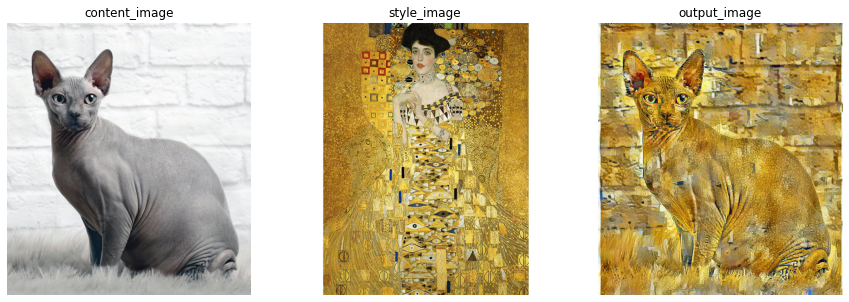

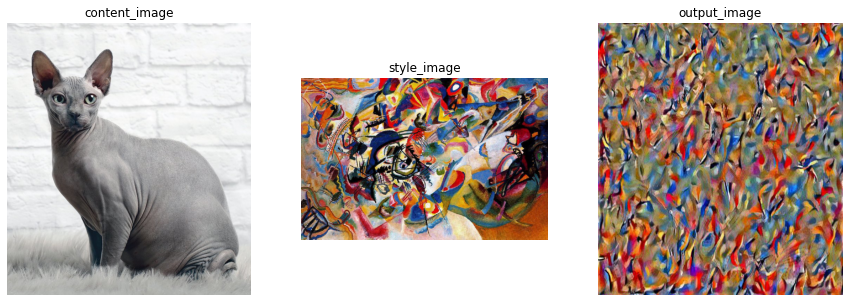

In [56]:
load_style_transfer_images(estimators)

Need to try more images... and 1 or 2 iterations max. Need to lower the style weight.

In [ ]:
s3://sagemaker-studio-sr1encmpcxc/pytorch-style-transfer22-2023-03-21-17-32-34-099/output/output.tar.gz

In [9]:
import matplotlib.pyplot as plt
import os

output_dir = './'
plt.savefig(os.path.join(output_dir, 'image.png'))

<Figure size 432x288 with 0 Axes>

# testing

In [5]:
import argparse
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from pathlib import Path
from PIL import Image


def image_loader(image_path: str, device: str):
    image = Image.open(image_path)
    loader = transforms.Compose([
        transforms.Resize(512),  # scale imported image
        transforms.ToTensor(),  # transform it into a torch tensor
    ])
    # Fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


device = "cpu"
style_image_path =  "sphynx_cat.jpg"
style_img = image_loader(style_image_path, device)

target_shape = style_img.shape[2:]
style_img_reshaped = transforms.Resize(target_shape)(style_img)

In [30]:




import argparse
import matplotlib.pyplot as plt
import os



if __name__=='__main__':
    
    
    import sys
    sys.argv = ["hpo.py", "--content_image", "sphynx_cat.jpg", "--data_dir", "./lala"]
    os.environ['SM_CHANNEL_DATA'] = "../project-files/dogImages/train"
    os.environ['SM_OUTPUT_DATA_DIR'] = "../project-files/dogImages/train"

    parser=argparse.ArgumentParser()
    parser.add_argument('--content_image', type=str)
    parser.add_argument('--data_dir', type=str, default=os.environ['SM_CHANNEL_DATA'])
    parser.add_argument('--output_dir', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    
    args=parser.parse_args()
    print(args)
    
    #output_dir = '/opt/ml/output/data/'
    output_dir = './'
    
    plt.savefig(os.path.join(output_dir, args.data_dir + args.content_image))
    
    


Namespace(content_image='sphynx_cat.jpg', data_dir='./lala', output_dir='../project-files/dogImages/train')


<Figure size 432x288 with 0 Axes>

In [2]:
# Code used to test that training job can read the images
from pathlib import Path

style_image_path = Path(args.style_data_dir) / args.style_image
content_image_path = Path(args.content_data_dir) / args.content_image

output_path = Path(OUTPUT_DIR) / "new_produced_image.jpg"
print('output_path', output_path)

img1 = Image.open(style_image_path)
img2 = Image.open(content_image_path)

# Get the dimensions of the first image
width1, height1 = img1.size

# Get the dimensions of the second image
width2, height2 = img2.size

# Calculate the width and height of the new image
new_width = width1 + width2
new_height = max(height1, height2)

# Create a new image with the calculated dimensions and a white background
new_image = Image.new('RGB', (new_width, new_height), (255, 255, 255))

# Paste the first image onto the new image
new_image.paste(img1, (0, 0))

# Paste the second image onto the new image, offset by the width of the first image
new_image.paste(img2, (width1, 0))

# Save the new image
new_image.save(output_path)

output_path output/new_produced_image.jpg
